#  Прогнозирование количества заказов такси

**Задача**: Построить модель для предсказания количества заказов такси на следующий час. Метрика RMSE модели на тестовой выборке не должна превышать 48.

**Дано**: Исторические данные о заказах такси в аэропортах

**План решения**:
1. Загрузить данные и выполнить их ресэмплирование по одному часу
2. Проанализировать данные
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
#Импортируем библиотеки и модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Создадим датафрейм
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
#Выведем первые 5 строк
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
#Выведем информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
#Изменим тип данных в столбце datetime на datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
#Установим индекс таблицы равным столбцу datetime
df.set_index('datetime', inplace=True)

In [7]:
#Проверим, в хоронологическом ли порядке расположены дата и время
df.index.is_monotonic

True

Дата и время расположены в хронологическом порядке, сортировка не требуется

In [8]:
#Выполним ресемплирование данных по 1 часу
df = df.resample('1H').sum()

## Анализ

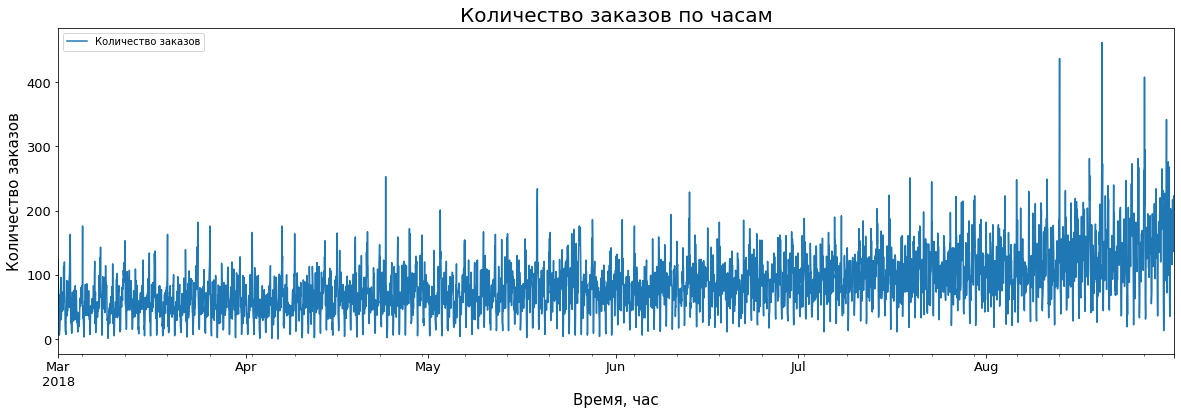

In [9]:
#Построим график по часам
plt.figure(figsize=(20, 6))
df.plot(ax=plt.gca(), fontsize=13);
plt.title(label = 'Количество заказов по часам', fontsize=20)
plt.xlabel('Время, час', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.legend(labels=['Количество заказов'], loc='upper left')
plt.show()

In [10]:
#Добавим скользящую среднюю с периодом 24 часа
df['rolling_mean'] = df.rolling(24).mean()

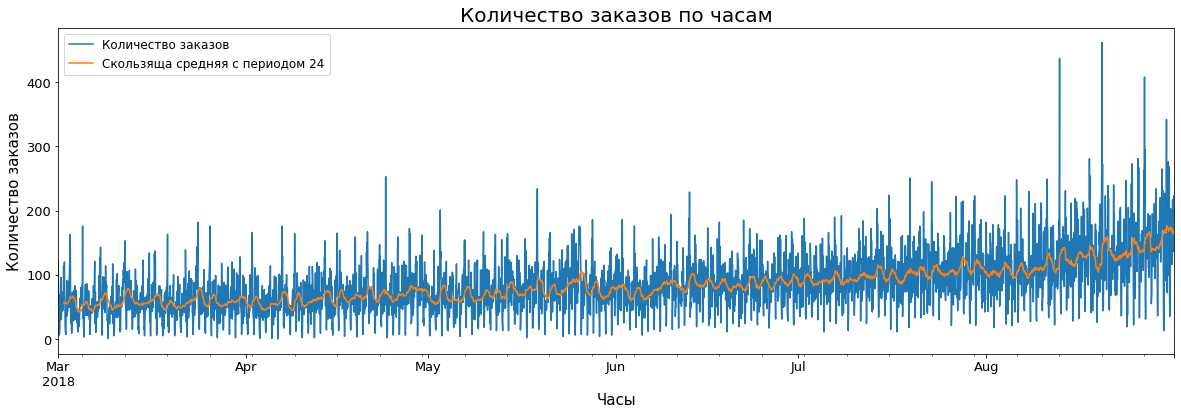

In [11]:
#Построим график вместе со скользящей средней
plt.figure(figsize=(20, 6))
plt.title(label = 'Количество заказов по часам', fontsize=20)
df.plot(ax=plt.gca(), fontsize=13);
plt.xlabel('Часы', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.legend(labels=['Количество заказов', 'Скользяща средняя с периодом 24'], loc='upper left', fontsize=12)
plt.show()

In [12]:
#Добавим новые признаки: час и день недели 
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

In [13]:
#Применим функция seasonal_decompose() для получения тренда и сезонности
decomposed = seasonal_decompose(df.drop(['rolling_mean', 'hour', 'day_of_week'], axis=1))

Выведем график тренда

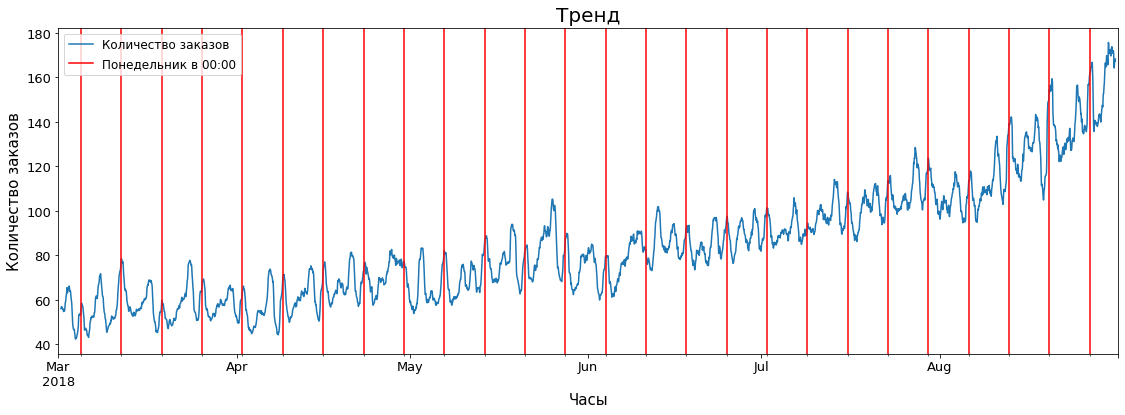

In [14]:
#Выведем график тренда
plt.figure(figsize=(19, 6))
decomposed.trend.plot(ax=plt.gca(), fontsize=13);
#Обозначим на графике понедельники в 00:00:00
for i in df.query('day_of_week == 0 & hour == 0').index:
    plt.axvline(i, color='r')
plt.xlabel('Часы', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.title('Тренд', fontsize=20)
plt.legend(labels=['Количество заказов', 'Понедельник в 00:00'], loc='upper left', fontsize=12)

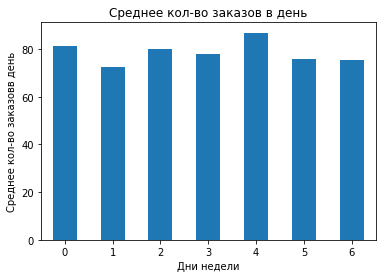

In [15]:
#Сгруппируем таблицу по дням недели и построим диаграмму
df.pivot_table(index='day_of_week', values='num_orders', aggfunc='median').plot(
    title='Среднее кол-во заказов в день',
    legend=None,
    rot=True,
    kind='bar', 
    xlabel='Дни недели', 
    ylabel='Среднее кол-во заказовв день',
);

Выведем график сезонности

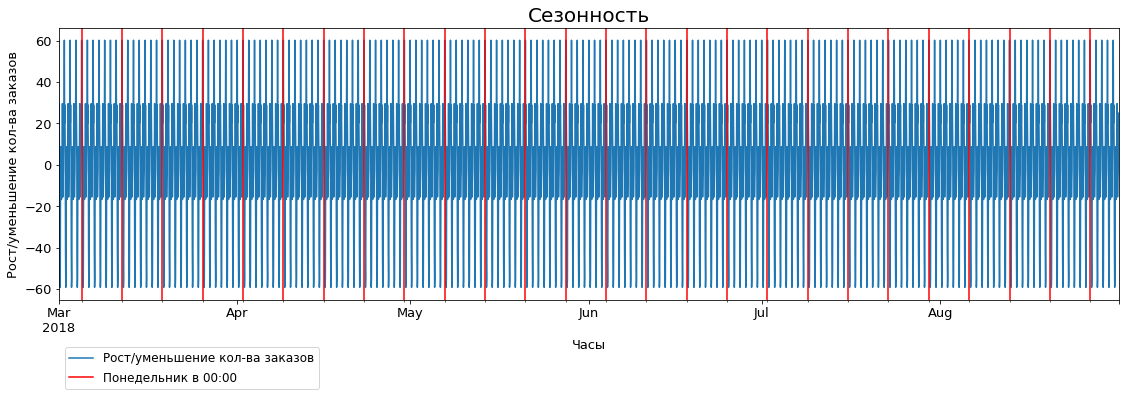

In [16]:
#Выведем график сезонности
plt.figure(figsize=(19, 5))
decomposed.seasonal.plot(ax=plt.gca(), fontsize=13);
#Обозначим на графике понедельники в 00:00:00
for i in df.query('day_of_week == 0 & hour == 0').index:
    plt.axvline(i, color='r')
plt.xlabel('Часы', fontsize=13)
plt.ylabel('Рост/уменьшение кол-ва заказов', fontsize=13)
plt.title('Сезонность', fontsize=20)
plt.legend(bbox_to_anchor=(0, -0.35), 
           loc="lower left", 
           labels=['Рост/уменьшение кол-ва заказов', 'Понедельник в 00:00'], 
           fontsize=12)

Выведем график сезонности за первый месяц

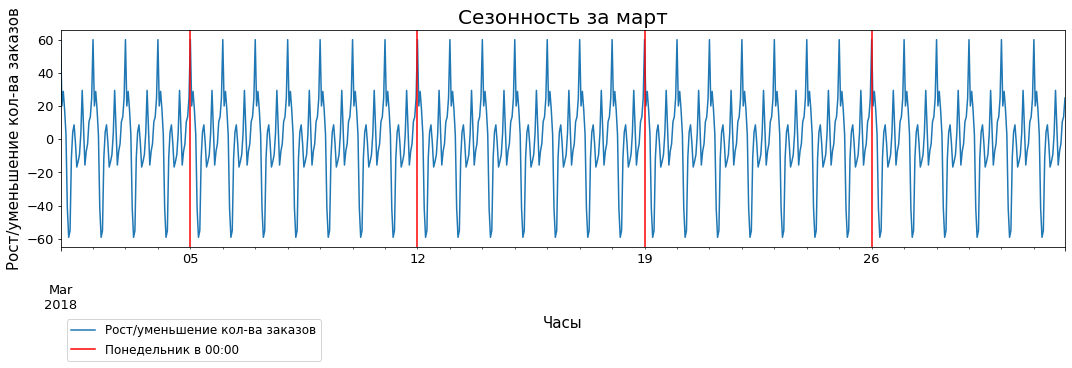

In [17]:
#Выведем график сезонности
plt.figure(figsize=(18, 4))
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca(), fontsize=13);
#Обозначим на графике понедельники в 00:00:00
for i in df.query('day_of_week == 0 & hour == 0').index:
    plt.axvline(i, color='r')
plt.xlabel('Часы', fontsize=15)
plt.ylabel('Рост/уменьшение кол-ва заказов', fontsize=15)
plt.title('Сезонность за март', fontsize=20)
plt.legend(bbox_to_anchor=(0, -0.55), 
           loc="lower left", 
           labels=['Рост/уменьшение кол-ва заказов', 'Понедельник в 00:00'], 
           fontsize=12)

Выведем график сезонности за первую неделю

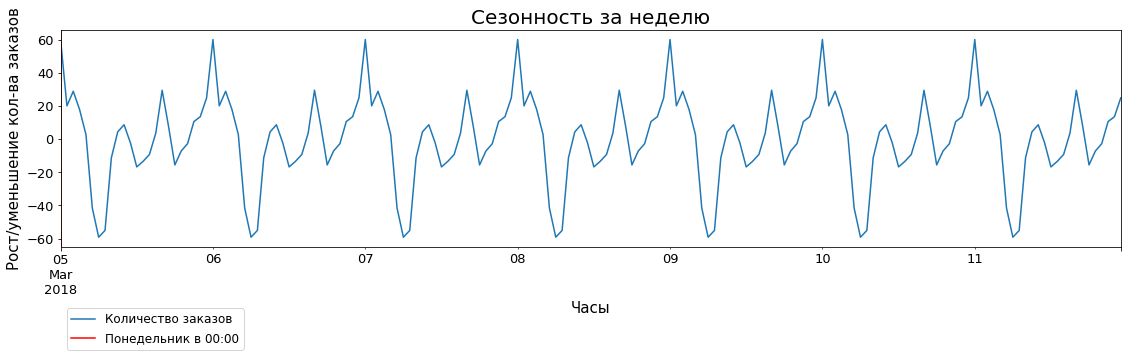

In [18]:
#Выведем график сезонности за неделю
plt.figure(figsize=(19, 4))
decomposed.seasonal['2018-03-05':'2018-03-11'].plot(ax=plt.gca(), fontsize=13);
#Обозначим на графике понедельники в 00:00:00
for i in df.query('day_of_week == 0 & hour == 0').index:
    plt.axvline(i, color='r')
plt.xlabel('Часы', fontsize=15)
plt.ylabel('Рост/уменьшение кол-ва заказов', fontsize=15)
plt.title('Сезонность за неделю', fontsize=20)
plt.legend(bbox_to_anchor=(0, -0.5), loc="lower left", labels=['Количество заказов', 'Понедельник в 00:00'], fontsize=12)

Выведем график сезонности за сутки

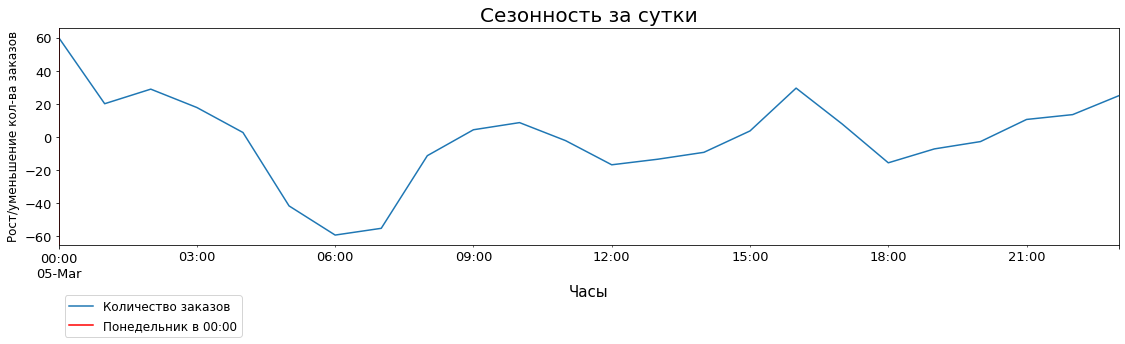

In [19]:
#Выведем график сезонности за сутки
plt.figure(figsize=(19, 4))
decomposed.seasonal['2018-03-05 00:00:00':'2018-03-05 23:00:00'].plot(ax=plt.gca(), fontsize=13);
#Обозначим на графике понедельники в 00:00:00
for i in df.query('day_of_week == 0 & hour == 0').index:
    plt.axvline(i, color='r')
plt.xlabel('Часы', fontsize=15)
plt.ylabel('Рост/уменьшение кол-ва заказов', fontsize=12)
plt.title('Сезонность за сутки', fontsize=20)
plt.legend(bbox_to_anchor=(0, -0.45), loc="lower left", labels=['Количество заказов', 'Понедельник в 00:00'], fontsize=12)

Выведем график остатков

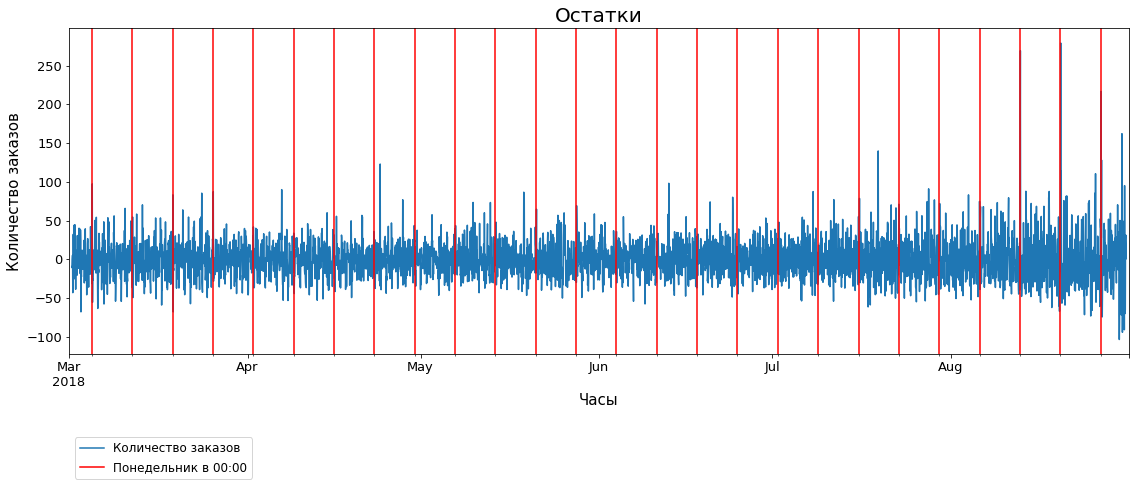

In [20]:
#Выведем график остатков
plt.figure(figsize=(19, 6))
decomposed.resid.plot(ax=plt.gca(), fontsize=13);
#Обозначим на графике понедельники в 00:00:00
for i in df.query('day_of_week == 0 & hour == 0').index:
    plt.axvline(i, color='r')
plt.xlabel('Часы', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.title('Остатки', fontsize=20)
plt.legend(bbox_to_anchor=(0, -0.4), loc="lower left", labels=['Количество заказов', 'Понедельник в 00:00'], fontsize=12)

**Вывод**: По графикам можно заметить закономерность: для большинства недель кол-во заказов падает в начале недели, затем растёт в середине недели, затем опять падает и к концу недели снова растёт, чтобы опять упасть в начале недели. Т.е. самое большое число заказов - в середине и в конце недели.<br>
В течение суток в 8:00 - 9:00 кол-во заказов практически не меняется. После этого времени кол-во заказов начинает уменьшаться на 10-20 за час, это уменьшение продолжается до 15:00. В 16:00 кол-во заказов вырастает примерно на 30, затем рост заказов резко уменьшается до 18:00, после этого времени уменьшение роста заказов замедляется а затем рост кол-ва заказов начинает увеличиваться.

In [22]:
#Создадим функцию для добавления новых признаков: кол-ва предидущих значений и периода скользящей средней
def make_features_nd(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

#Вызываем так
df_new = make_features_nd(df, 168, 24)

Исходя из наблюдений, добавим новые признаки:
- max_lag = 168 - для учёта часов за прошлую неделю (24 * 7 = 168)
- rolling_mean_size = 24 - период скользящей средней в 24 часа

In [23]:
make_features_nd(df, 24, 24)

## Обучение

In [24]:
#Выделим обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

#Выделим признаки и целевой признак
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Обучим модели и подберём гиперпараметры

**Линейная регрессия**

In [25]:
%%time

model_lr = LinearRegression()

#Найдём значение метрики RMSE с помощью кросс-валидации
final_scores = []
scores = cross_val_score(model_lr, 
                         X_train, 
                         y_train, 
                         scoring='neg_root_mean_squared_error', 
                         cv=TimeSeriesSplit(n_splits=5))
final_scores.append(scores.mean())

final_rmse = pd.Series(final_scores).mean()*(-1)
print('Среднее значение метрики RMSE:', final_rmse)

Среднее значение метрики RMSE: 27.13572866332756
CPU times: user 307 ms, sys: 929 ms, total: 1.24 s
Wall time: 1.18 s


**Ridge**

In [26]:
%%time

# Объявляем модель
model_ridge = Ridge(random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {'alpha': np.arange(0, 0.21, 0.01)}

gs_ridge = GridSearchCV(model_ridge, 
                        cv=TimeSeriesSplit(n_splits=5), 
                        scoring='neg_root_mean_squared_error', 
                        param_grid=param_grid_ridge
)

gs_ridge.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметры: {gs_ridge.best_params_}')

best RMSE: 27.112055112995836
Гиперпараметры: {'alpha': 0.0}
CPU times: user 3.1 s, sys: 6.28 s, total: 9.38 s
Wall time: 9.32 s


**RandomForestRegressor**

In [30]:
%%time

model_rf = RandomForestRegressor(random_state=12345)

param_grid = {'n_estimators': [100, 200],
              'max_depth': np.arange(5, 31, 5)
             }

grid_search = GridSearchCV(model_rf, 
                           cv=TimeSeriesSplit(n_splits=5), 
                           scoring='neg_root_mean_squared_error', 
                           param_grid=param_grid
                          )

grid_search.fit(X_train, y_train)

print('RMSE:', grid_search.best_score_*-1)
print('Гиперпараметры:', grid_search.best_params_)

RMSE: 22.76087784794051
Гиперпараметры: {'max_depth': 15, 'n_estimators': 200}
CPU times: user 19min 27s, sys: 2.44 s, total: 19min 29s
Wall time: 19min 30s


**LGBMRegressor**

In [23]:
%%time

#Объявим модель
model_lgb = LGBMRegressor(random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgb = {'n_estimators': [100, 200], 'max_depth': np.arange(4, 13, 4),}

gs_lgb = GridSearchCV(
    model_lgb, 
    cv=TimeSeriesSplit(n_splits=5), 
    param_grid=param_grid_lgb, 
    scoring='neg_root_mean_squared_error', 
)

gs_lgb.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'RMSE: {gs_lgb.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметы: {gs_lgb.best_params_}')

RMSE: 22.87526255470175
Гиперпараметы: {'max_depth': 4, 'n_estimators': 100}
CPU times: user 25min 51s, sys: 12.7 s, total: 26min 4s
Wall time: 26min 13s


**CatBoostRegressor**

In [24]:
%%time

#Объявим модель
model_cb = CatBoostRegressor(verbose=False, random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_cb = {'n_estimators': [100, 200], 'max_depth': [4, 8, 12]}

gs_cb = GridSearchCV(
    model_cb, 
    cv=TimeSeriesSplit(n_splits=5), 
    param_grid=param_grid_cb, 
    scoring='neg_root_mean_squared_error', 
)

gs_cb.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE: {gs_cb.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметы: {gs_cb.best_params_}')

best RMSE: 22.96835090105093
Гиперпараметы: {'max_depth': 4, 'n_estimators': 200}
CPU times: user 35min 12s, sys: 7.3 s, total: 35min 19s
Wall time: 35min 45s


Наименьшее значение метрики RMSE = 22.544647162459277 показаал модель **Ridge** с гиперапарметром alpha = 0.2

## Тестирование

Проверим модель **Ridge** на тестовой выборке.

In [27]:
model_ridge = Ridge(alpha=0.2, random_state=12345)
model_ridge.fit(X_train, y_train)
predicted_ridge = model_ridge.predict(X_test)
print("RMSE =", mean_squared_error(y_test, predicted_ridge) ** 0.5)

RMSE = 45.178105781239275


Построим сравнительный график значений и предсказаний

In [26]:
#Создадим таблицу с результатами и предсказаниями
comparative_data = pd.concat([y_test.reset_index(), pd.Series(predicted_ridge)], axis=1)
comparative_data.columns = ['date_time', 'target', 'predictions']
comparative_data['predictions'] = comparative_data['predictions'].astype(int)
comparative_data.set_index('date_time', inplace=True)
comparative_data

,target,predictions
date_time,,
2018-08-13 14:00:00,102,121
2018-08-13 15:00:00,175,128
2018-08-13 16:00:00,144,187
2018-08-13 17:00:00,152,133
2018-08-13 18:00:00,104,92
...,...,...
2018-08-31 19:00:00,136,124
2018-08-31 20:00:00,154,166
2018-08-31 21:00:00,159,182


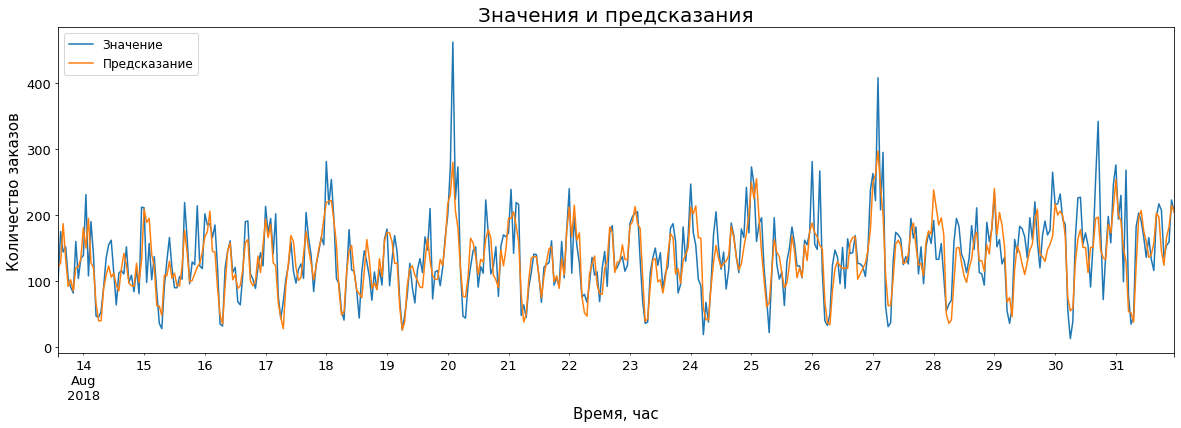

In [27]:
#Построим сравнительный график
plt.figure(figsize=(20, 6))
comparative_data.plot(ax=plt.gca(), fontsize=13);
plt.title(label = 'Количество заказов по часам', fontsize=18)
plt.xlabel('Время, час', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.title('Значения и предсказания', fontsize=20)
plt.legend(labels=['Значение', 'Предсказание'], loc='upper left', fontsize=12)
plt.show()

## Общий вывод

По условиям задачи необходимо было разработать модель для предсказания количества заказов такис на следующий час. Были предоставлены данные о количестве заказов такси в аэропортах.<br><br>
В ходе работы были проведены этапы:<br>
1. Загрузка и подготовка данных
2. Ресемплирование данных по требуемому временному интервалу (1 час)
3. Анализ данных, на его основе добавление новых признаков для обучения моделей
4. Обучение моделей с подбором гиперпараметров
5. Поиск лучшей модели с минимальной метрикой RMSE на тестовой выборке